# Prologue

In [1]:
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from trixs.spectra.util import NumpyEncoder
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
import json
import os
import numpy as np
import sklearn
import pandas as pd
import numpy as np
rseed = 42
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cm as cm
import matplotlib.colors as colors
import collections

storage_directory = '/Users/steventorrisi/Documents/TRIXS/data/MP_OQMD_combined'

target_elements_groups=[('Co','O'),('Ti','O')]#,('Fe','O'),('V','O'),('Cu','O'),
                       # ('Ni','O'),('Cr','O'),('Mn','O'),('Ti','O')]

from trixs.machine_learning.benchmarks import precision_recall_matrix, confusion_dict

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


greens = truncate_colormap(cm.get_cmap('Greens'),minval=0.0,maxval=1.0,n=100)
reds = truncate_colormap(cm.get_cmap('Reds'),0,1,100)
good_norm = plt.Normalize(vmin=.5, vmax=1)
bad_norm = plt.Normalize(vmin=0, vmax=.5)


In [3]:
data_by_pair = {pair:[] for pair in target_elements_groups}

models_by_pair = {pair:None for pair in target_elements_groups}
x_valid_by_pair = {pair:None for pair in target_elements_groups}
y_valid_by_pair = {pair:None for pair in target_elements_groups}

for pair in tqdm_notebook(target_elements_groups):
    target_file = storage_directory + '/{}_{}_polynomials_pre-post_XY.json'.format(pair[0],pair[1])
    with open(target_file, 'r') as f:
        for line in f.readlines():
            cur_data = json.loads(line)
            if cur_data.get('one_hot_coord'):
                data_by_pair[pair].append(cur_data)

    sorted_keys = sorted(list(data_by_pair[pair][0]['labeled_coefficients'].keys()))
    
    X = []
    Y = []    
    for point in data_by_pair[pair]:
        X.append([point['labeled_coefficients'][key] for key in sorted_keys])
        Y.append(point['coordination'])

    X = np.array(X)
    Y = np.array(Y)
    print("Classes for {}: {}".format(pair,collections.Counter(Y)))
    
    x_train, x_test, y_train, y_test = \
      train_test_split(X, Y, test_size=0.1,
                   random_state=42)
    x_train, x_valid, y_train, y_valid = \
      train_test_split(x_train, y_train, test_size=0.2,
                       random_state=42)
        
    forest =  RandomForestClassifier(n_estimators = 200,
                                    max_depth = 25,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    max_features = 20,
                                    random_state=42)

    forest.fit(x_train,y_train)
    models_by_pair[pair] = forest
    x_valid_by_pair[pair] = x_valid
    y_valid_by_pair[pair] = y_valid


Classes for ('Co', 'O'): Counter({6: 1707, 5: 764, 4: 560})
Classes for ('Ti', 'O'): Counter({6: 3889, 5: 1991, 4: 388})



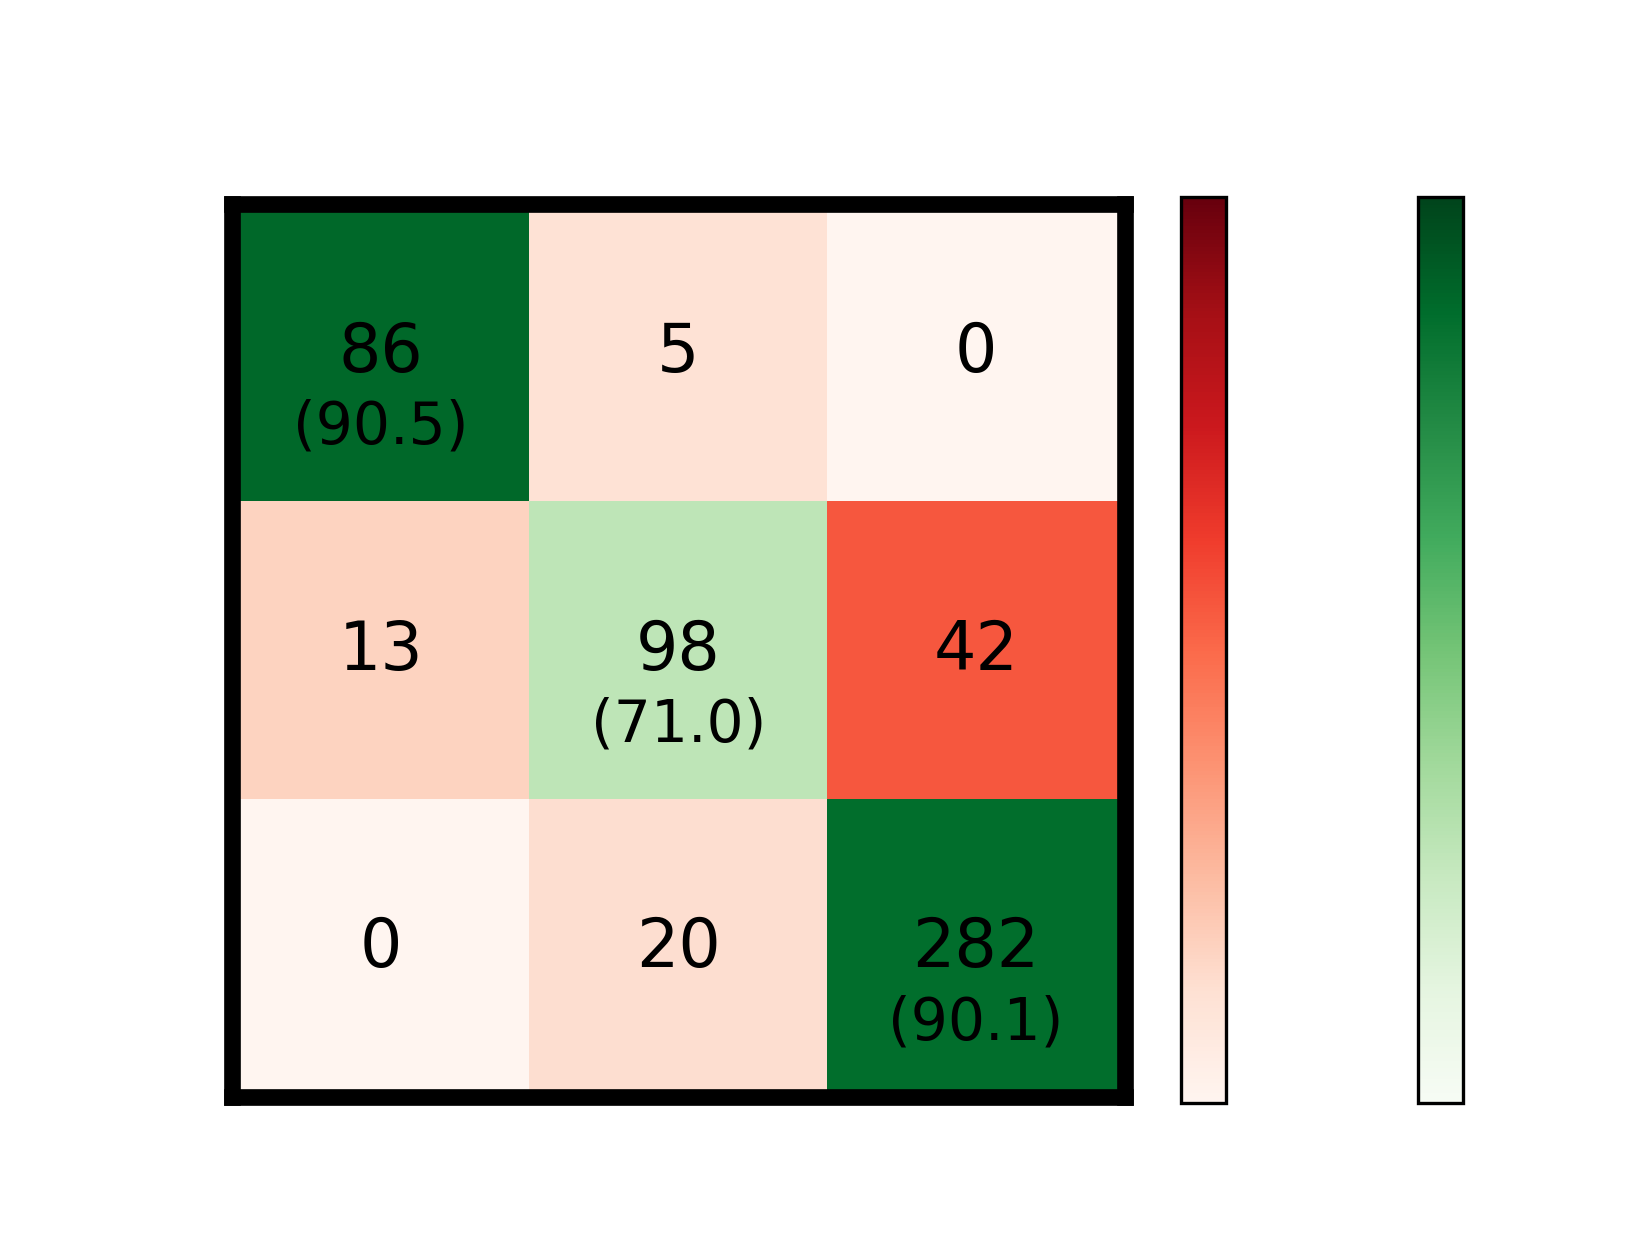

546


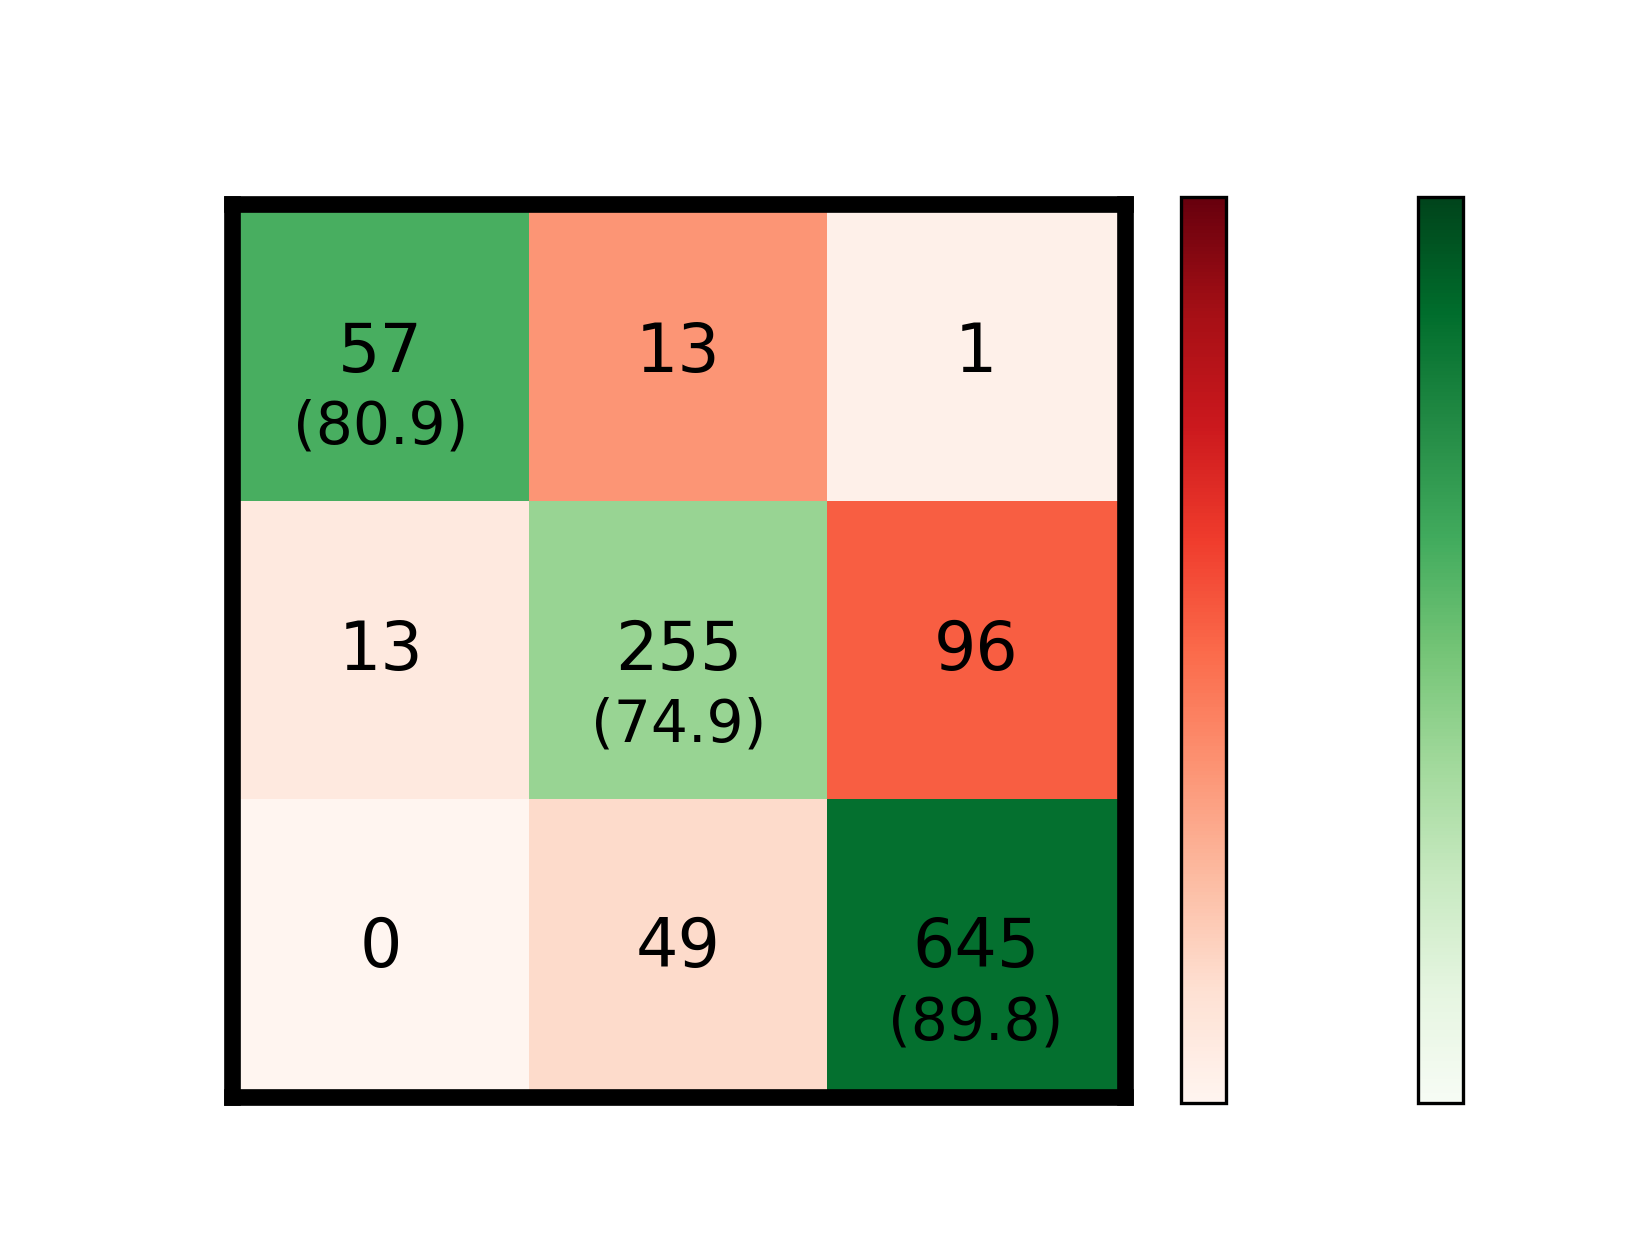

1129


In [4]:
import matplotlib as mpl
mpl.rcParams['text.color'] = 'white'
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

for pair in target_elements_groups:
    forest = models_by_pair[pair]
    guesses = forest.predict(x_valid_by_pair[pair])
    labels = y_valid_by_pair[pair]
    conf_mat = confusion_dict(guesses,labels,[4,5,6])
    f1_score = precision_recall_matrix(guesses,labels,[4,5,6])
    f1s = [np.round(100*x[2],1) for x in f1_score]
    conf_mat = np.array([conf_mat[c] for c in [4,5,6]])
    percent_mat = np.copy(conf_mat).astype('float64')
    fig = plt.figure(1,dpi=300)
    ax = fig.add_subplot(111,autoscale_on = True)
    sums = np.sum(conf_mat,axis=1,dtype='float64')

    for i in range(3):
        percent_mat[i,:]=percent_mat[i,:]/sums[i]

    wrong_mat = np.array([[True,False,False],[False,True,False],[False,False,True]])
    correct_mat = np.array([[False,True,True],[True,False,True],[True,True,False]])

    correct_masked = np.ma.masked_array(percent_mat,correct_mat)
    wrong_masked = np.ma.masked_array(percent_mat,wrong_mat)

    cor_ax = ax.imshow(correct_masked, cmap=cm.get_cmap('Greens'),norm=good_norm,
                      origin='upper')
    wro_ax = ax.imshow(wrong_masked, cmap=cm.get_cmap("Reds"),norm=bad_norm,
                      origin='upper')
    cla = plt.colorbar(cor_ax)
    clb = plt.colorbar(wro_ax)
    cla.set_label("% Class Right")
    clb.set_label("% Class Wrong")

    min_val, max_val = 0,3
    ind_array = np.arange(min_val + 0.0, max_val+0.0, 1.0)
    x,y = np.meshgrid(ind_array,ind_array)

    for i, (x_val,y_val) in enumerate(zip(x.flatten(),y.flatten())):

        value = conf_mat[i//3][i%3]
        ax.text(x_val,y_val,value, va='center',ha='center',color='black',size = 16)
        if i in[0,4,8]:
            ax.text(x_val,y_val+.25,'({})'.format(f1s[i//3]), va='center',ha='center',color='black',size = 14)

    ax.set_yticks([2,1,0])

    ax.set_yticklabels(["6-Fold",'5-Fold','4-Fold'])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["4-Fold","5-Fold","6-Fold"])
    ax.set_ylim(2.5,-.5)
    ax.set_xlim(-.5,2.5)
    ax.set_ylabel("Spectra Labels")
    ax.set_xlabel("Spectra Fitted")
    ax.spines['left'].set_linewidth(4)
    ax.spines['top'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['right'].set_linewidth(4)
    ax.tick_params(axis=u'both', which=u'both',length=0)

    ax.set_title("{} Coordination \n Confusion Matrix \n  (F1 Score on Diagonal)".format(pair[0]))
    plt.show()
    print(len(x_valid_by_pair[pair]))